In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import sys

import re
import time
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

%matplotlib inline

# Extract Word2Vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [2]:
from array import array

def lcsubstrings(seq1, seq2, positions=False):
	"""Find the longest common substring(s) in the sequences `seq1` and `seq2`.
	
	If positions evaluates to `True` only their positions will be returned,
	together with their length, in a tuple:
	
		(length, [(start pos in seq1, start pos in seq2)..])
	
	Otherwise, the substrings themselves will be returned, in a set.
	
	Example:
	
		>>> lcsubstrings("sedentar", "dentist")
		{'dent'}
		>>> lcsubstrings("sedentar", "dentist", positions=True)
		(4, [(2, 0)])
	"""
	L1, L2 = len(seq1), len(seq2)
	ms = []
	mlen = last = 0
	if L1 < L2:
		seq1, seq2 = seq2, seq1
		L1, L2 = L2, L1
	
	column = array('L', range(L2))
	
	for i in range(L1):
		for j in range(L2):
			old = column[j]
			if seq1[i] == seq2[j]:
				if i == 0 or j == 0:
					column[j] = 1
				else:
					column[j] = last + 1
				if column[j] > mlen:
					mlen = column[j]
					ms = [(i, j)]
				elif column[j] == mlen:
					ms.append((i, j))
			else:
				column[j] = 0
			last = old
	
	if positions:
		return (mlen, tuple((i - mlen + 1, j - mlen + 1) for i, j in ms if ms))
	return set(seq1[i - mlen + 1:i + 1] for i, _ in ms if ms)


In [40]:
df = pd.read_csv("train.csv")
print("Number of data points:",df.shape[0])

df.head()

Number of data points: 20972


ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   
2        0            1           0                     0   
3        0            1           0                     0   
4        0            0           1                     0   

   Quantitative Finance  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20972 entries, 0 to 20971
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   ID                    20972 non-null  int64 
 1   TITLE                 20972 non-null  object
 2   ABSTRACT              20972 non-null  object
 3   Computer Science      20972 non-null  int64 
 4   Physics               20972 non-null  int64 
 5   Mathematics           20972 non-null  int64 
 6   Statistics            20972 non-null  int64 
 7   Quantitative Biology  20972 non-null  int64 
 8   Quantitative Finance  20972 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 1.4+ MB


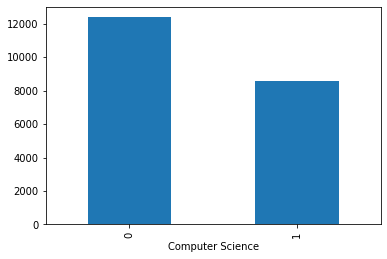

In [10]:
df.groupby("Computer Science")['ID'].count().plot.bar()

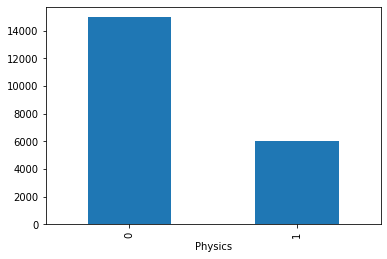

In [11]:
df.groupby("Physics")['ID'].count().plot.bar()

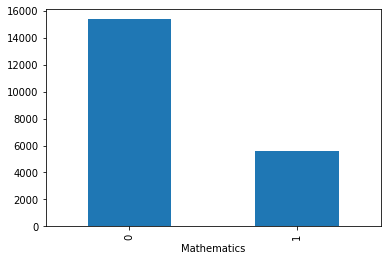

In [12]:
df.groupby("Mathematics")['ID'].count().plot.bar()

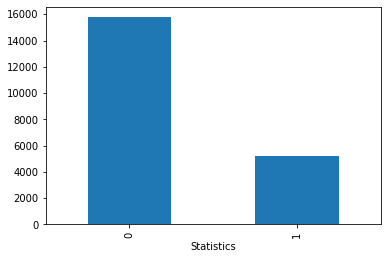

In [13]:
df.groupby("Statistics")['ID'].count().plot.bar()

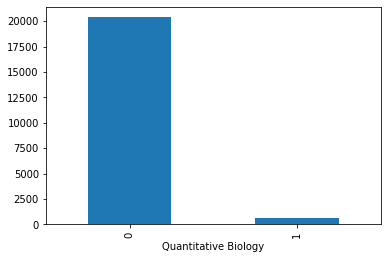

In [14]:
df.groupby("Quantitative Biology")['ID'].count().plot.bar()

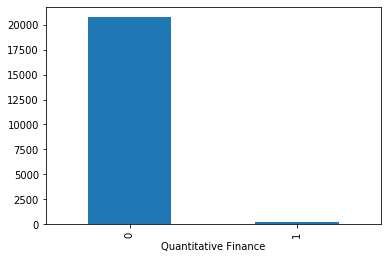

In [15]:

df.groupby("Quantitative Finance")['ID'].count().plot.bar()

In [16]:
print('~> Total number of samples for training:\n   {}'.format(len(df)))
print('~> Papers belonging Computer Science:\n   {}%'.format(round(df['Computer Science'].mean()*100, 2)))
print('~> Papers belonging Physics:\n   {}%'.format(round(df['Physics'].mean()*100, 2)))
print('~> Papers belonging Mathetics:\n   {}%'.format(round(df['Mathematics'].mean()*100, 2)))
print('~> Papers belonging Statistics:\n   {}%'.format(round(df['Statistics'].mean()*100, 2)))
print('~> Papers belonging Quantitative Biology:\n   {}%'.format(round(df['Quantitative Biology'].mean()*100, 2)))
print('~> Papers belonging Quantitative Finance:\n   {}%'.format(round(df['Quantitative Finance'].mean()*100, 2)))

~> Total number of samples for training:
   20972
~> Papers belonging Computer Science:
   40.98%
~> Papers belonging Physics:
   28.67%
~> Papers belonging Mathetics:
   26.79%
~> Papers belonging Statistics:
   24.82%
~> Papers belonging Quantitative Biology:
   2.8%
~> Papers belonging Quantitative Finance:
   1.19%


In [17]:
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [ID, TITLE, ABSTRACT, Computer Science, Physics, Mathematics, Statistics, Quantitative Biology, Quantitative Finance]
Index: []


In [41]:
df['q1len'] = df['TITLE'].str.len() 
df['q2len'] = df['ABSTRACT'].str.len()
df['q1_n_words'] = df['TITLE'].apply(lambda row: len(row.split(" ")))
df['q2_n_words'] = df['ABSTRACT'].apply(lambda row: len(row.split(" ")))

def normalized_word_Common(row):
    w1 = set(map(lambda word: word.lower().strip(), row['TITLE'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row["ABSTRACT"].split(" ")))    
    return 1.0 * len(w1 & w2)
df['word_Common'] = df.apply(normalized_word_Common, axis=1)

def normalized_word_Total(row):
    w1 = set(map(lambda word: word.lower().strip(), row['TITLE'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['ABSTRACT'].split(" ")))    
    return 1.0 * (len(w1) + len(w2))
df['word_Total'] = df.apply(normalized_word_Total, axis=1)

def normalized_word_share(row):
    w1 = set(map(lambda word: word.lower().strip(), row['TITLE'].split(" ")))
    w2 = set(map(lambda word: word.lower().strip(), row['ABSTRACT'].split(" ")))    
    return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
df['word_share'] = df.apply(normalized_word_share, axis=1)

df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

ID                                              TITLE  \
0   1        Reconstructing Subject-Specific Effect Maps   
1   2                 Rotation Invariance Neural Network   
2   3  Spherical polyharmonics and Poisson kernels fo...   
3   4  A finite element approximation for the stochas...   
4   5  Comparative study of Discrete Wavelet Transfor...   

                                            ABSTRACT  Computer Science  \
0    Predictive models allow subject-specific inf...                 1   
1    Rotation invariance and translation invarian...                 1   
2    We introduce and develop the notion of spher...                 0   
3    The stochastic Landau--Lifshitz--Gilbert (LL...                 0   
4    Fourier-transform infra-red (FTIR) spectra o...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   
2        0            1           0                     0   
3        0            1           0                     0   
4        0            0           1                     0   

   Quantitative Finance  q1len  q2len  q1_n_words  q2_n_words  word_Common  \
0                     0     43   1912           4         242          2.0   
1                     0     34    513           4          72          3.0   
2                     0     70    668           8          93          8.0   
3                     0     91    783           9         102          4.0   
4                     0    142    860          20         116         12.0   

   word_Total  word_share  
0       170.0    0.011765  
1        59.0    0.050847  
2        62.0    0.129032  
3        81.0    0.049383  
4       109.0    0.110092

For Computer Science


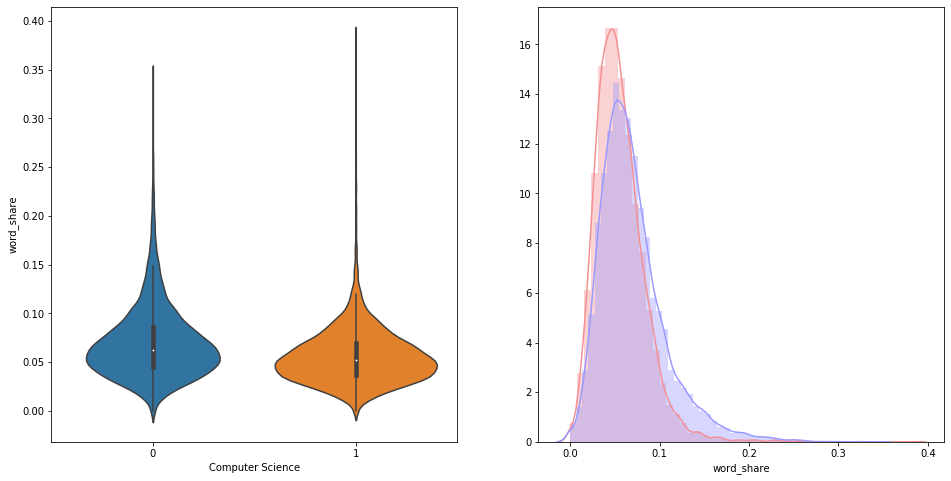

For Physics


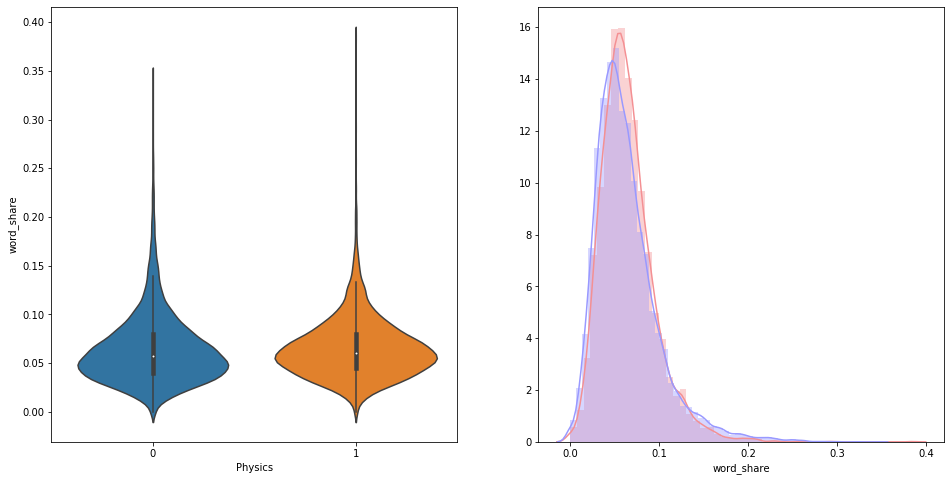

For Mathematics


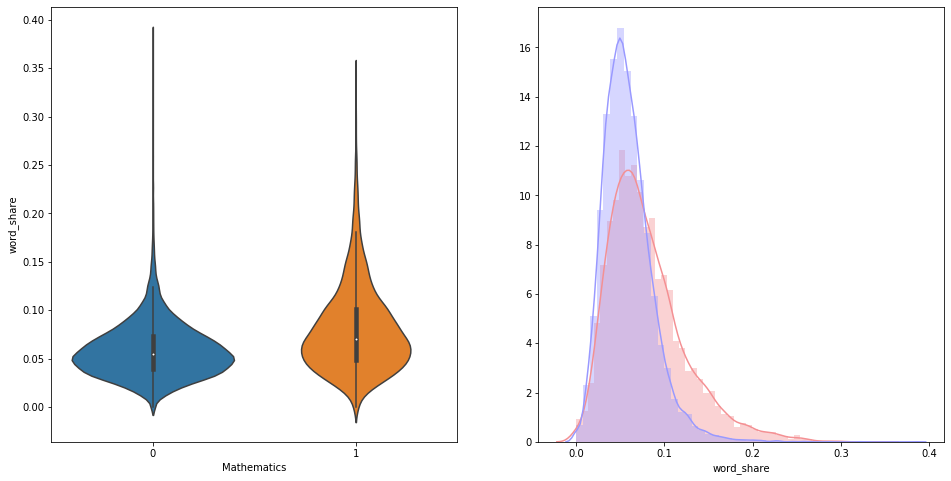

For Statistics


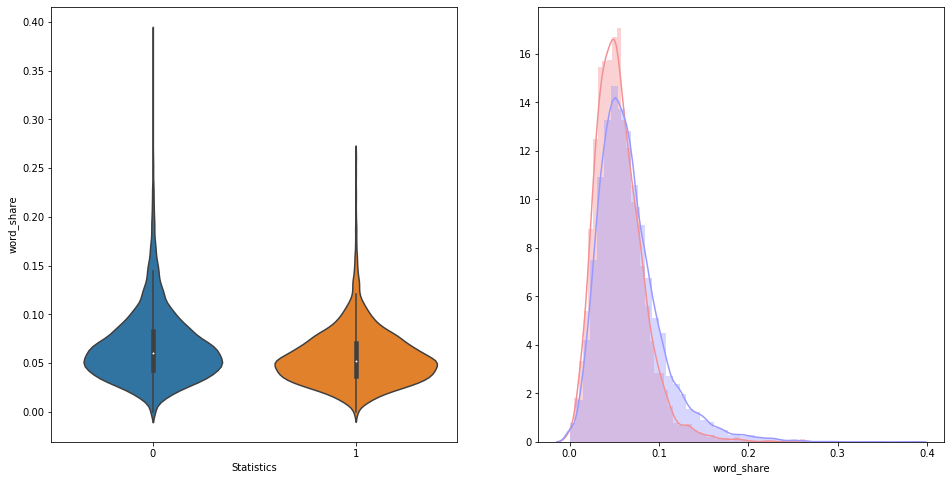

For Quantitative Biology


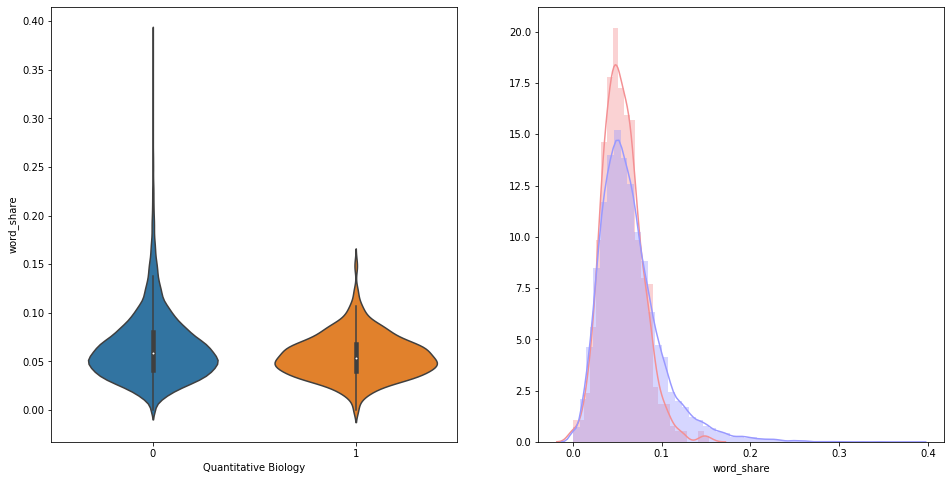

For Quantitative Finance


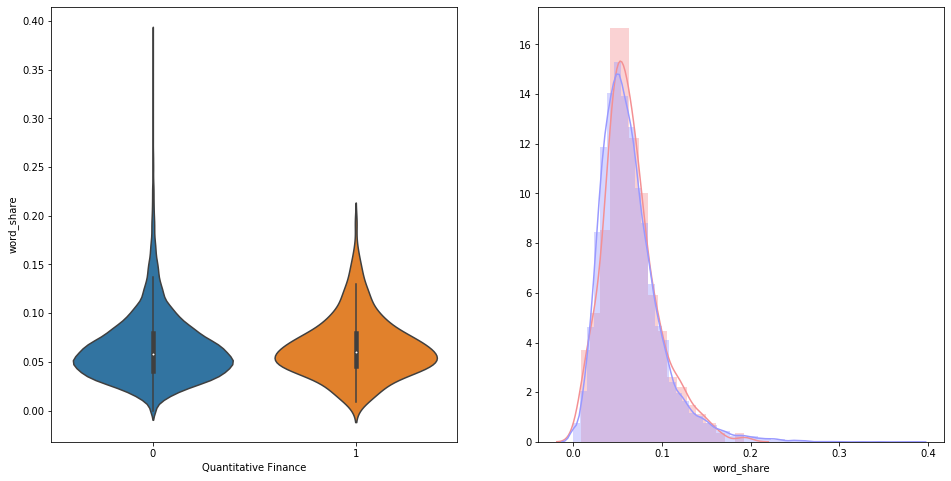

In [22]:
col=df.columns
col=col[3:9]
for i in col:
    plt.figure(figsize=(16, 8))

    plt.subplot(1,2,1)
    sns.violinplot(x = i, y = 'word_share', data = df[0:])

    plt.subplot(1,2,2)
    sns.distplot(df[df[i] == 1.0]['word_share'][0:] , kde = True, label = "1", color = '#f49093')
    sns.distplot(df[df[i] == 0.0]['word_share'][0:] , kde = True, label = "0" , color = '#9999ff')
    print("For "+i)
    plt.show()

for Computer Science


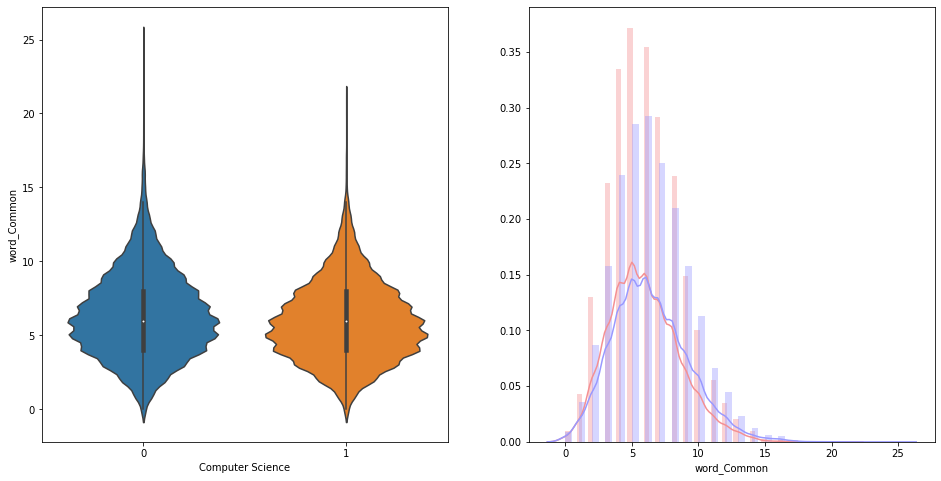

for Physics


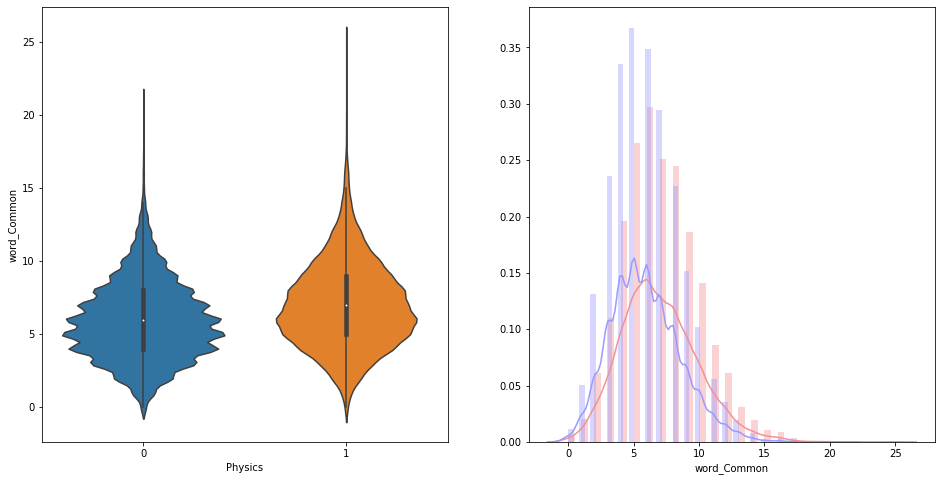

for Mathematics


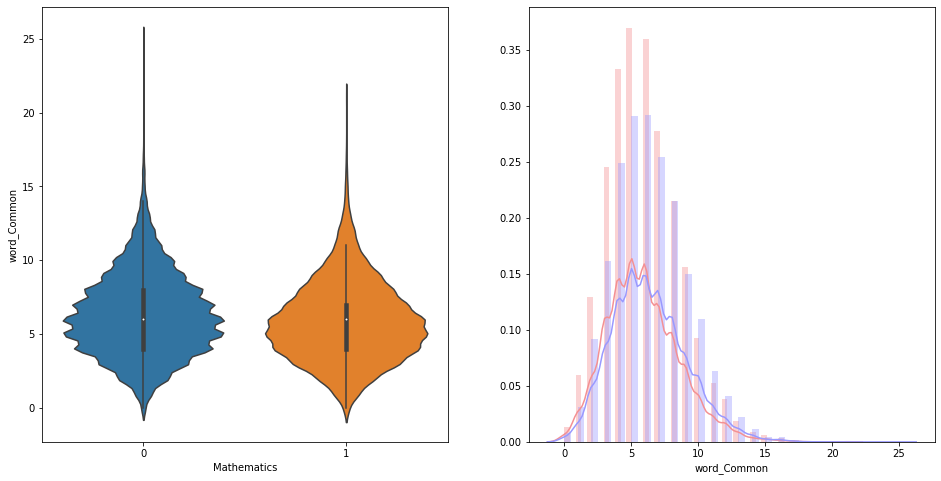

for Statistics


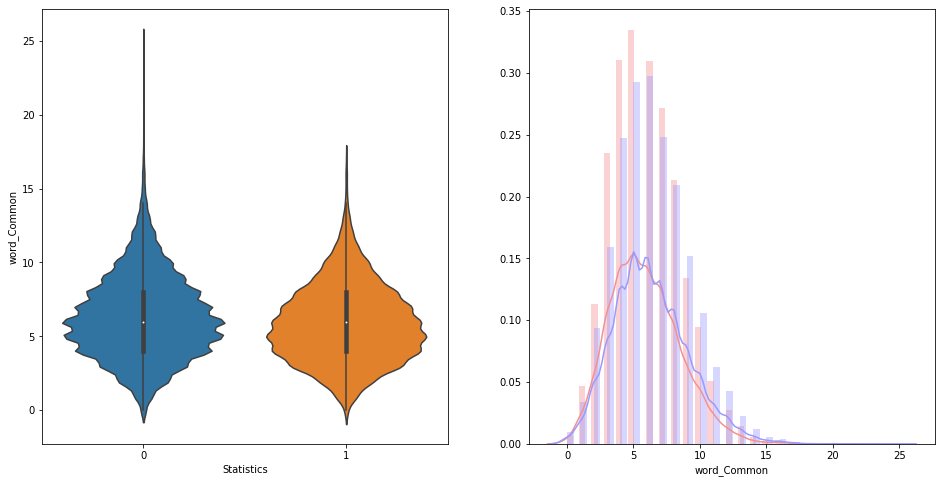

for Quantitative Biology


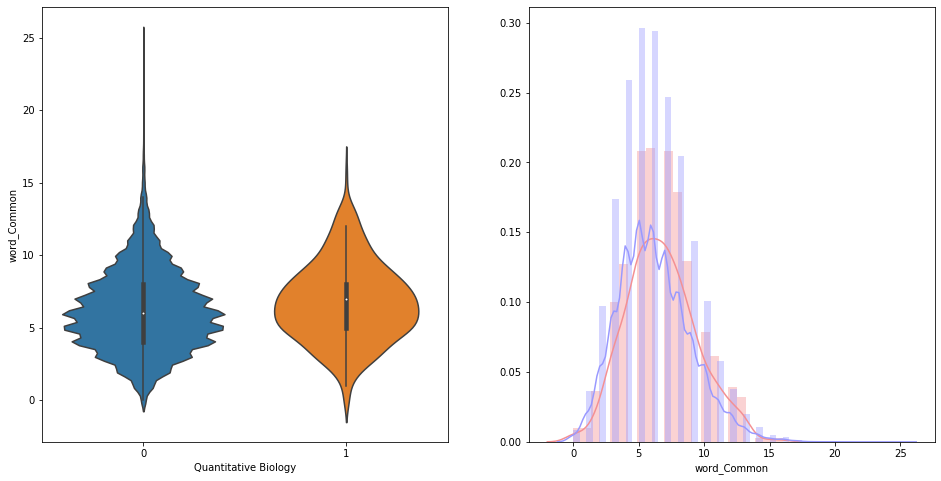

for Quantitative Finance


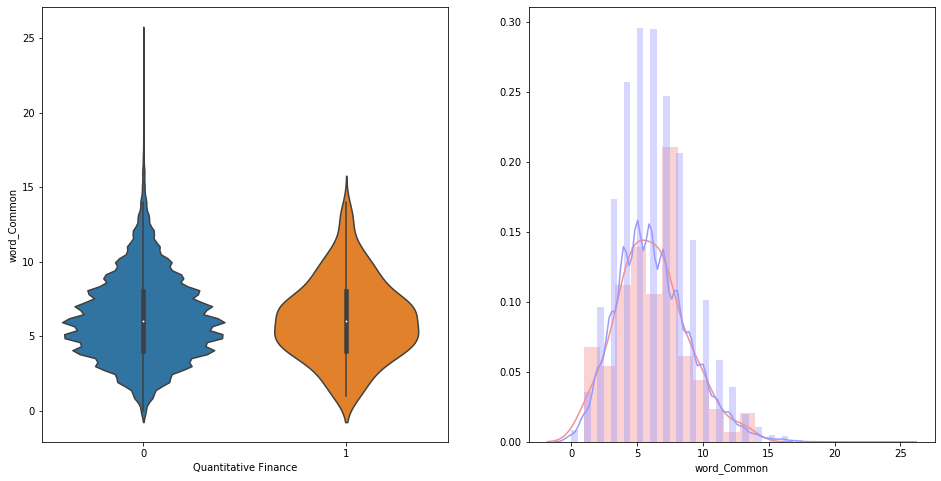

In [24]:
col=df.columns
col=col[3:9]
for i in col:
    plt.figure(figsize=(16, 8))

    plt.subplot(1,2,1)
    sns.violinplot(x = i, y = 'word_Common', data = df[0:])

    plt.subplot(1,2,2)
    sns.distplot(df[df[i] == 1.0]['word_Common'][0:] , kde = True, label = "1", color = '#f49093')
    sns.distplot(df[df[i] == 0.0]['word_Common'][0:] , kde = True, label = "0" , color = '#9999ff')
    print("for "+i)
    plt.show()

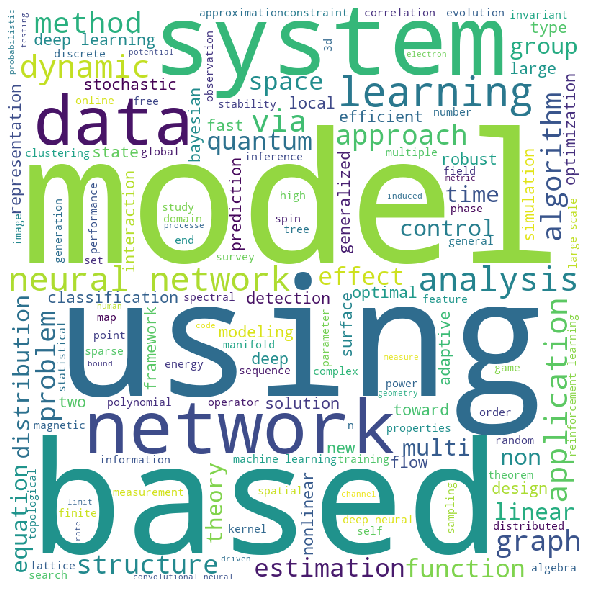

In [25]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads 'Youtube04-Eminem.csv' file
#dp =df['TITLE']

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df['TITLE']:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


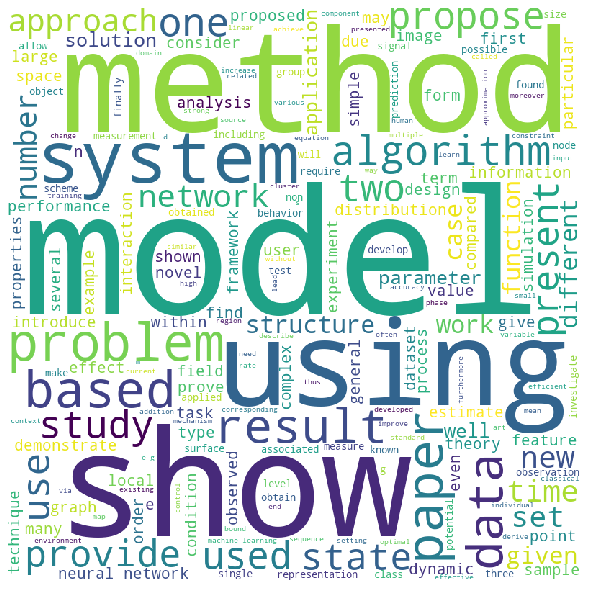

In [26]:
# Python program to generate WordCloud

# importing all necessary modules
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Reads 'Youtube04-Eminem.csv' file
#dp =df['TITLE']

comment_words = ''
stopwords = set(STOPWORDS)

# iterate through the csv file
for val in df['ABSTRACT']:
	
	# typecaste each val to string
	val = str(val)

	# split the value
	tokens = val.split()
	
	# Converts each token into lowercase
	for i in range(len(tokens)):
		tokens[i] = tokens[i].lower()
	
	comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
				background_color ='white',
				stopwords = stopwords,
				min_font_size = 10).generate(comment_words)

# plot the WordCloud image					
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()


Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')


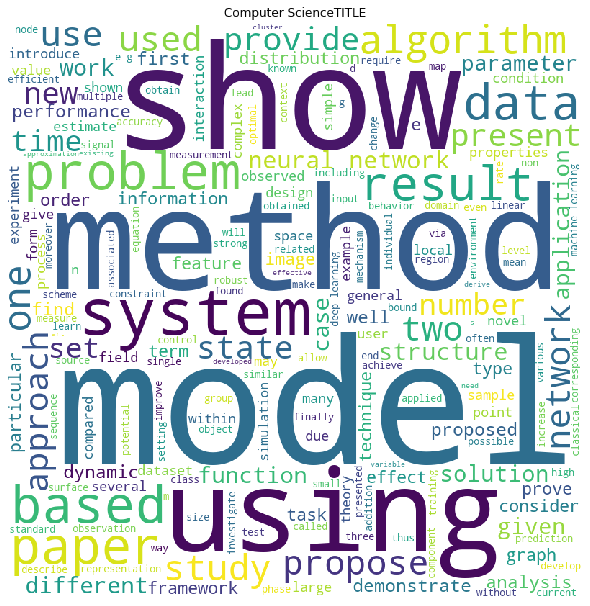

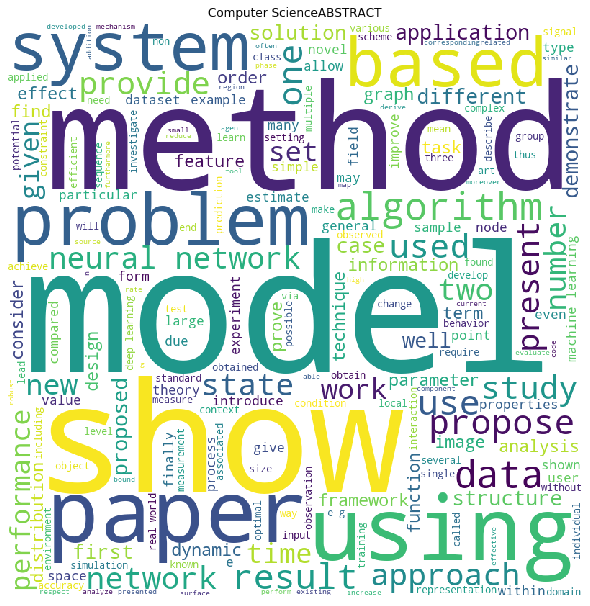

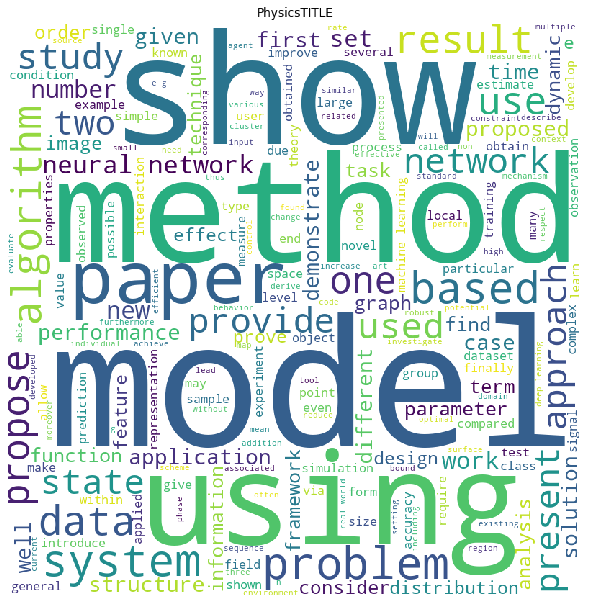

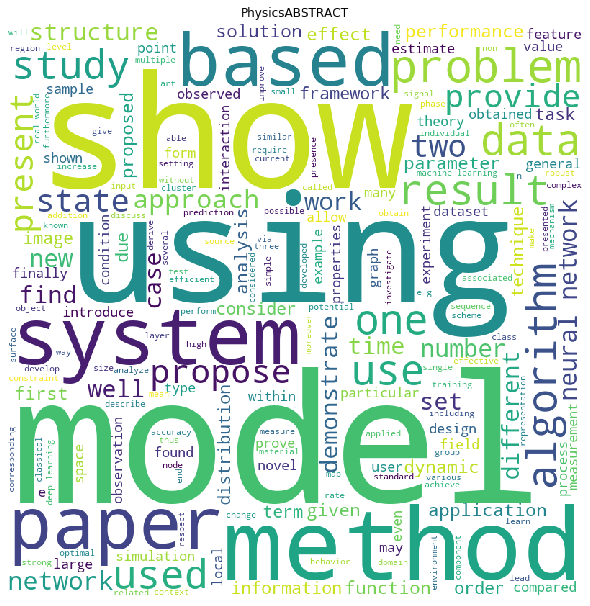

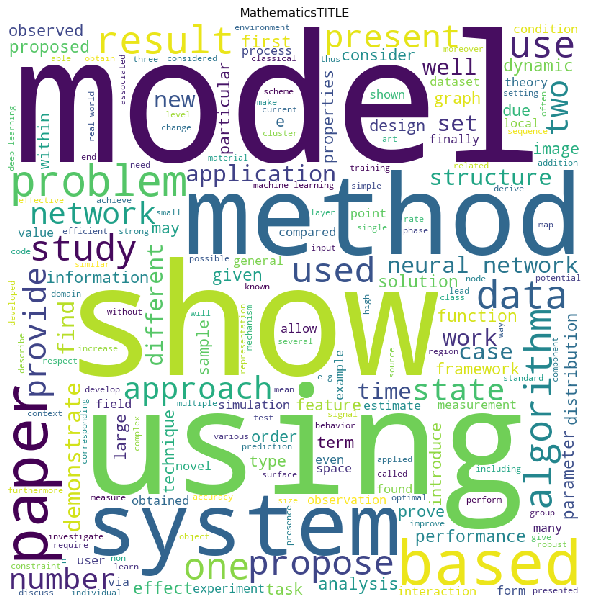

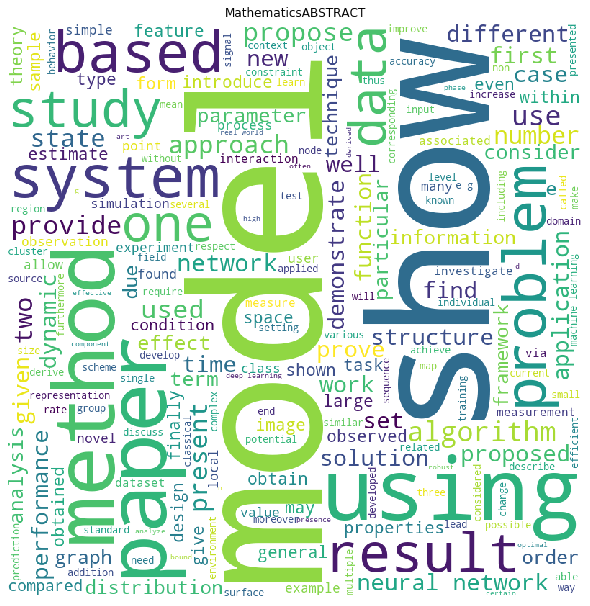

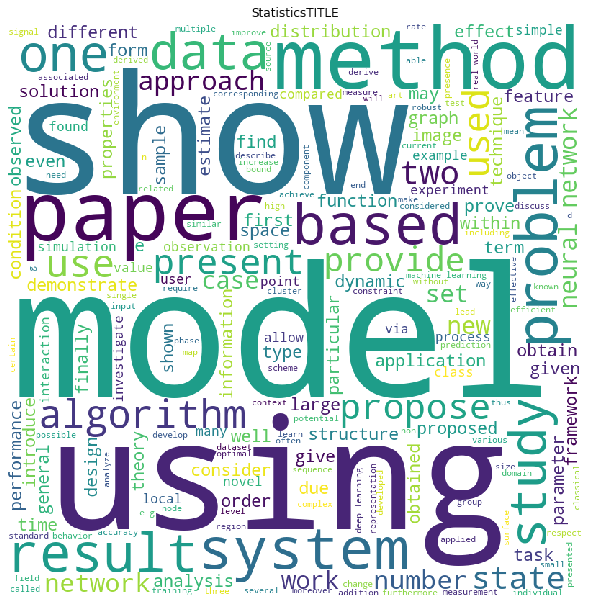

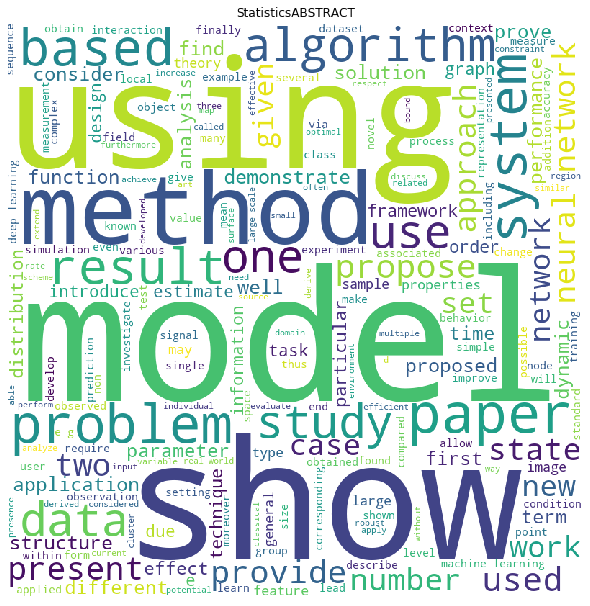

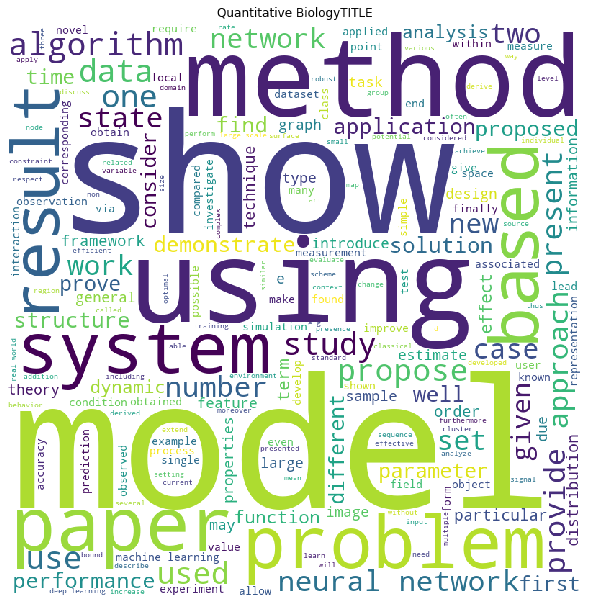

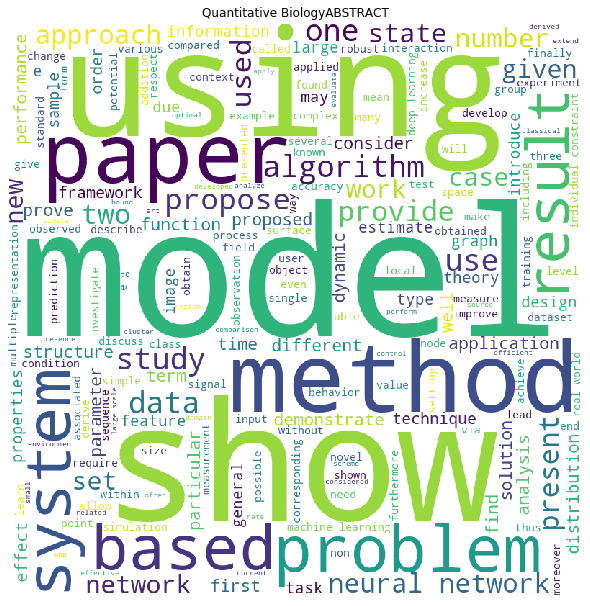

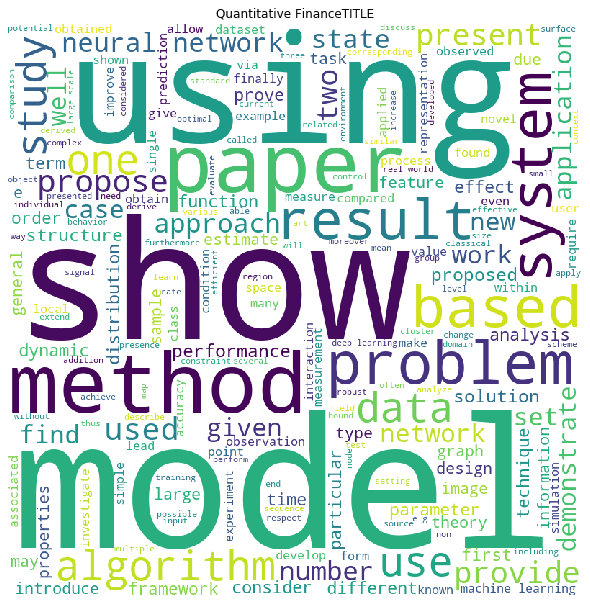

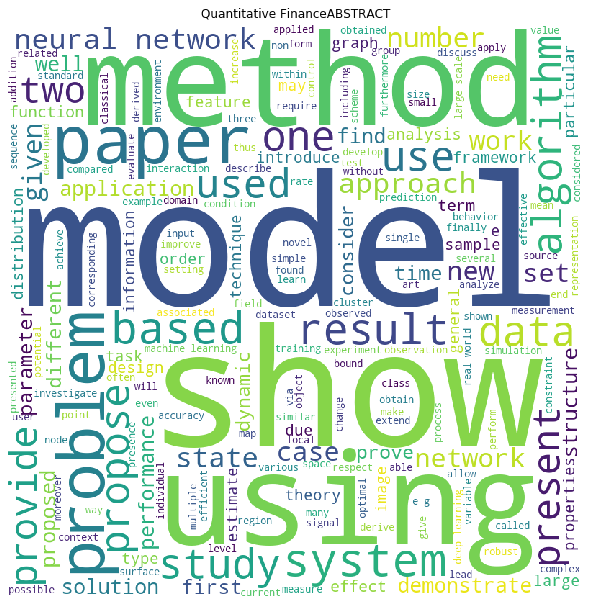

In [27]:
col=df.columns
col=col[3:9]
print(col)
for k in col:
    df_new = df[df[k] == 1]
    l=['TITLE','ABSTRACT']
    for j in l:
        for val in df_new[j]:

            # typecaste each val to string
            val = str(val)

            # split the value
            tokens = val.split()

            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()

            comment_words += " ".join(tokens)+" "

        wordcloud = WordCloud(width = 800, height = 800,
                        background_color ='white',
                        stopwords = stopwords,
                        min_font_size = 10).generate(comment_words)

        # plot the WordCloud image					
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.title(k+j)
        plt.show()

In [28]:
SAFE_DIV = 0.0001 
STOP_WORDS = set(STOPWORDS)

def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
       .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
       .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
       .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
       .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
       .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
       .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    return x

In [42]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    # Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features
# Get the Longest Common sub string
def get_longest_substr_ratio(a, b):
    strs = list(lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)



def extract_features(df):
    # Pre-processing each question
    df["TITLE"] = df["TITLE"].fillna("").apply(preprocess)
    df["ABSTRACT"] = df["ABSTRACT"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    token_features = df.apply(lambda x: get_token_features(x["TITLE"], x["ABSTRACT"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    # Computing Fuzzy Features and Merging with Dataset
    # Do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["TITLE"], x["ABSTRACT"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["TITLE"], x["ABSTRACT"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["TITLE"], x["ABSTRACT"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["TITLE"], x["ABSTRACT"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["TITLE"], x["ABSTRACT"]), axis=1)
    return df

In [46]:
df = extract_features(df)
df.to_csv("nlp_features_train.csv", index=False)

df.head(2)

token features...
fuzzy features..


ID                                       TITLE  \
0   1  reconstructing subject specific effect map   
1   2          rotation invariance neural network   

                                            ABSTRACT  Computer Science  \
0  predictive models allow subject specific infer...                 1   
1  rotation invariance and translation invariance...                 1   

   Physics  Mathematics  Statistics  Quantitative Biology  \
0        0            0           0                     0   
1        0            0           0                     0   

   Quantitative Finance  q1len  ...   ctc_max  last_word_eq  first_word_eq  \
0                     0     43  ...  0.010563             0              0   
1                     0     34  ...  0.050000             0              1   

   abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  fuzz_ratio  \
0           279     144.5               71                 1           2   
1            76      42.0              100                 4           9   

   fuzz_partial_ratio  longest_substr_ratio  
0                  60              0.651163  
1                  76              0.571429  

[2 rows x 31 columns]

Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')
For Computer Science


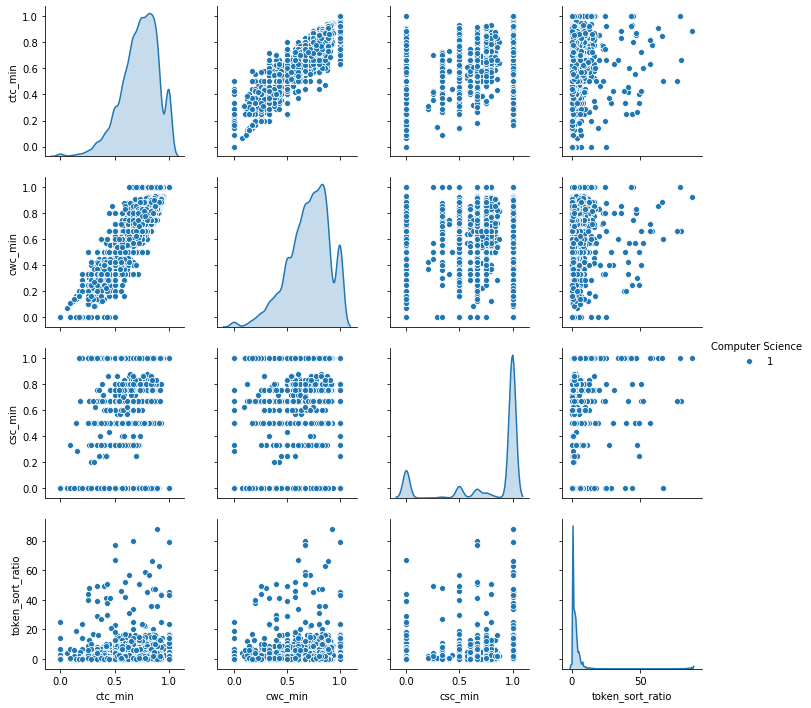

For Physics


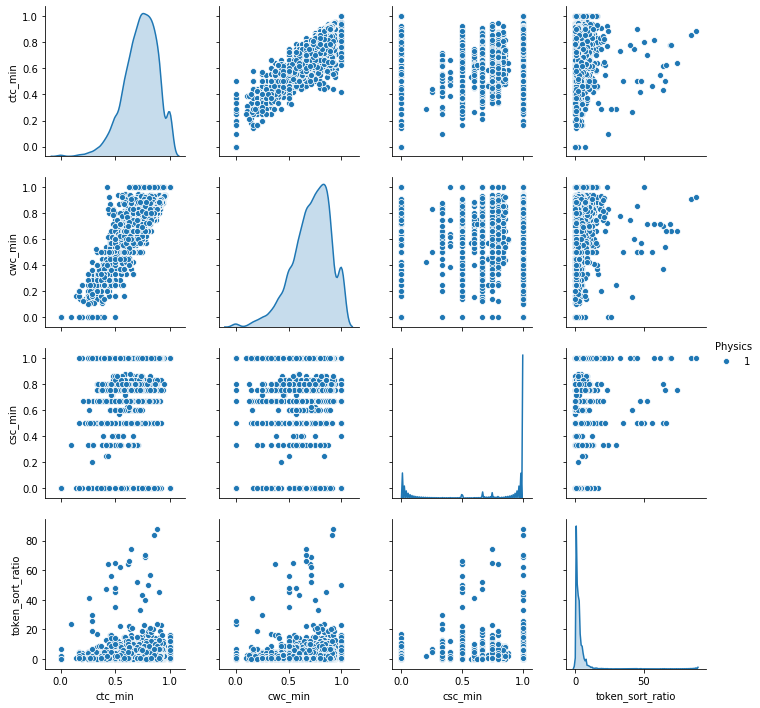

For Mathematics


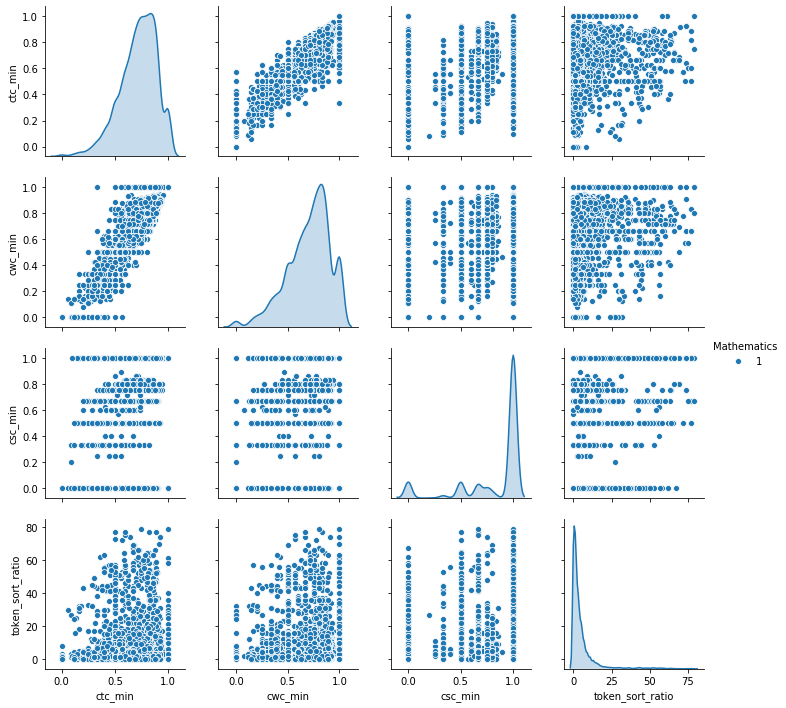

For Statistics


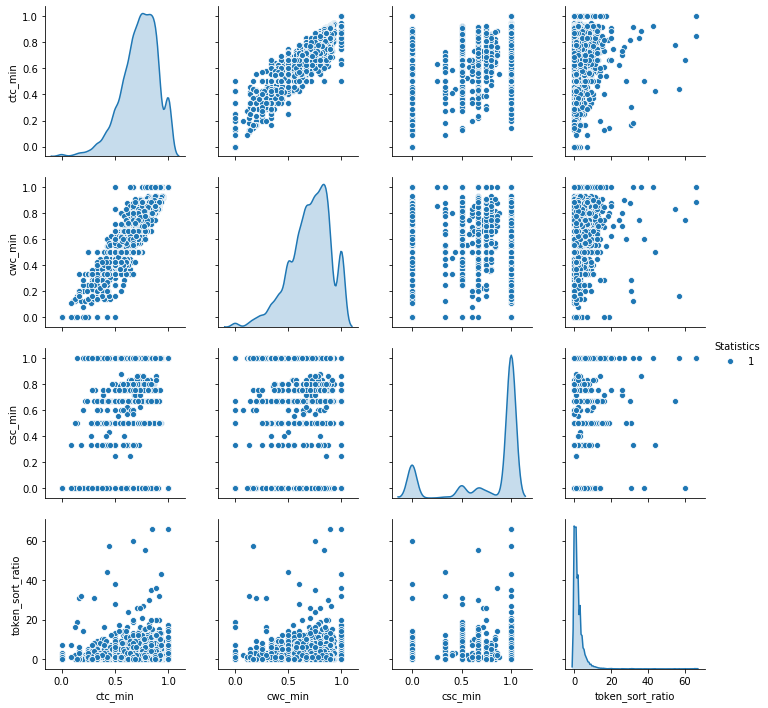

For Quantitative Biology


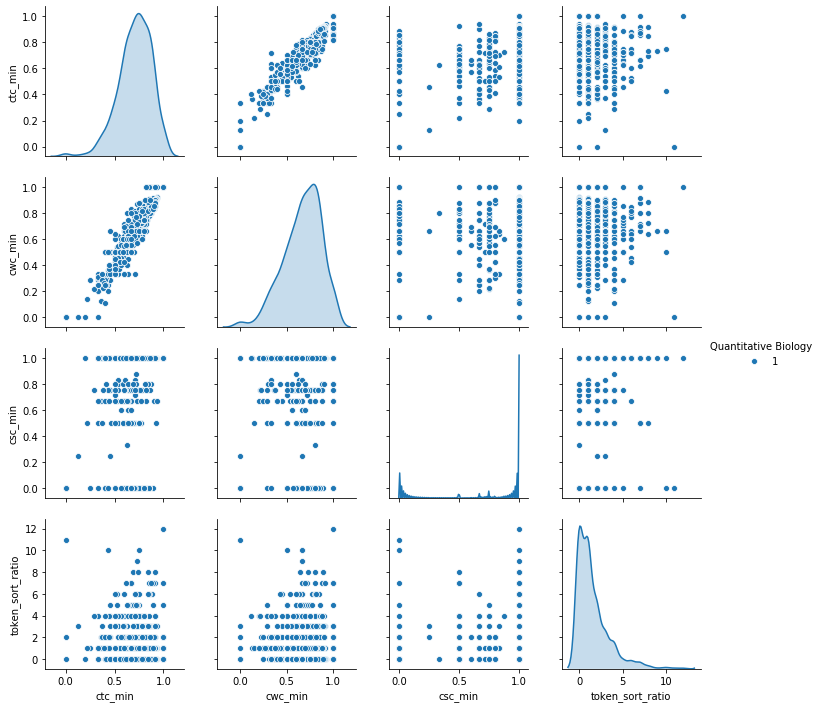

For Quantitative Finance


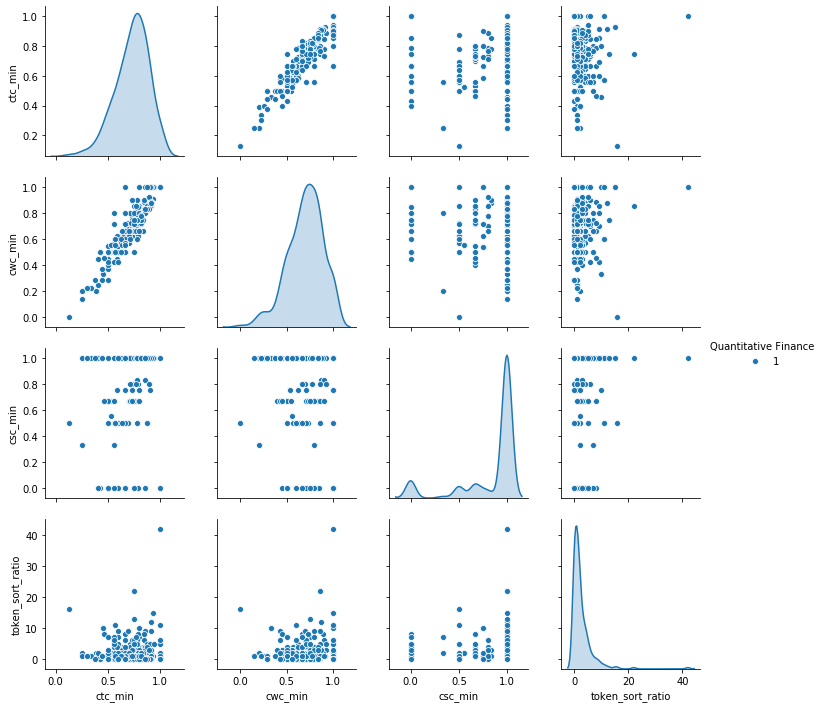

In [31]:
col=df.columns
col=col[3:9]
print(col)
for k in col:
    df_new = df[df[k] == 1]
    n = df_new.shape[0]
    sns.pairplot(df_new[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio',k]][0:n], hue=k , vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
    print("For "+k)
    plt.show()

Index(['Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance'],
      dtype='object')
for Computer Science


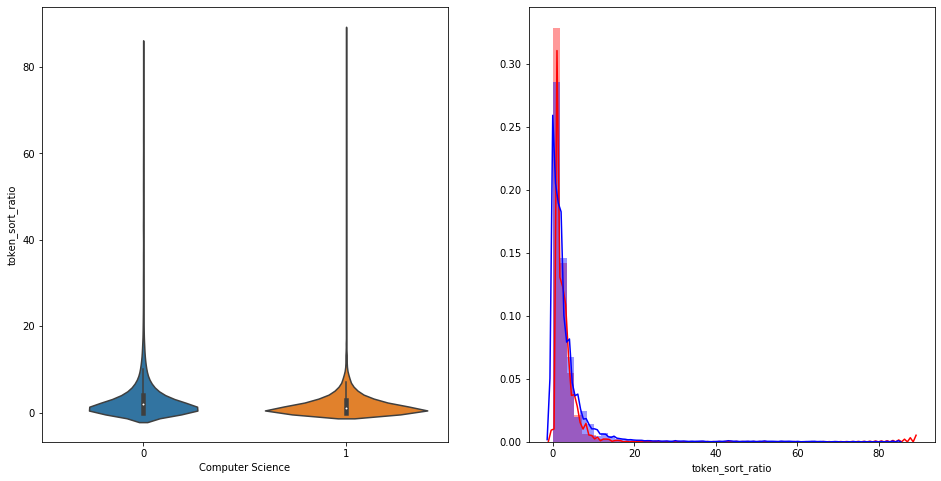

for Physics


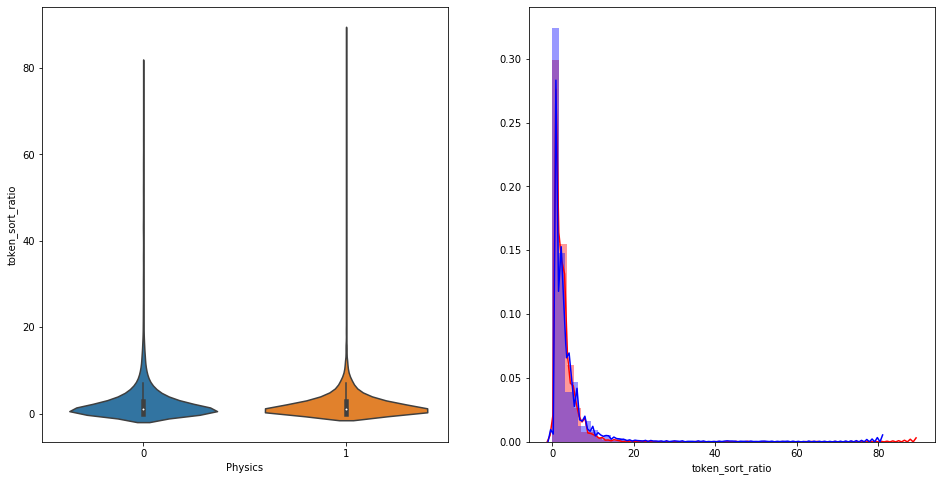

for Mathematics


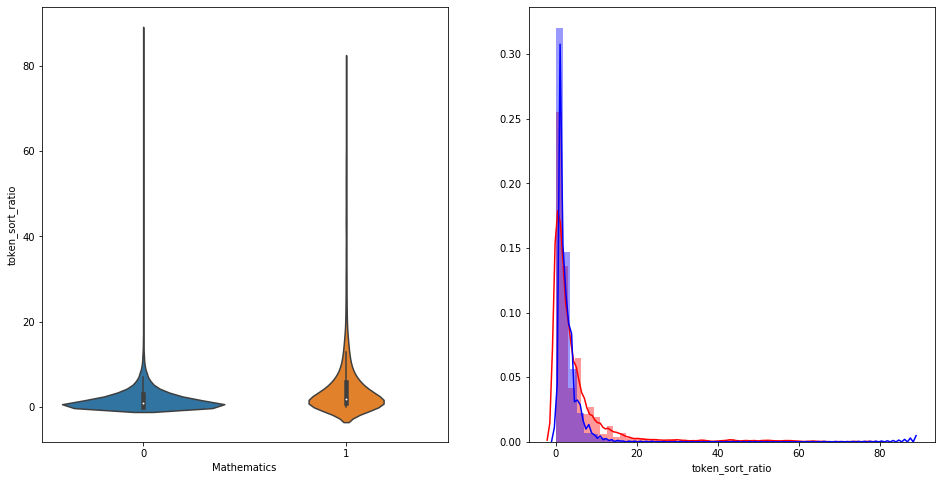

for Statistics


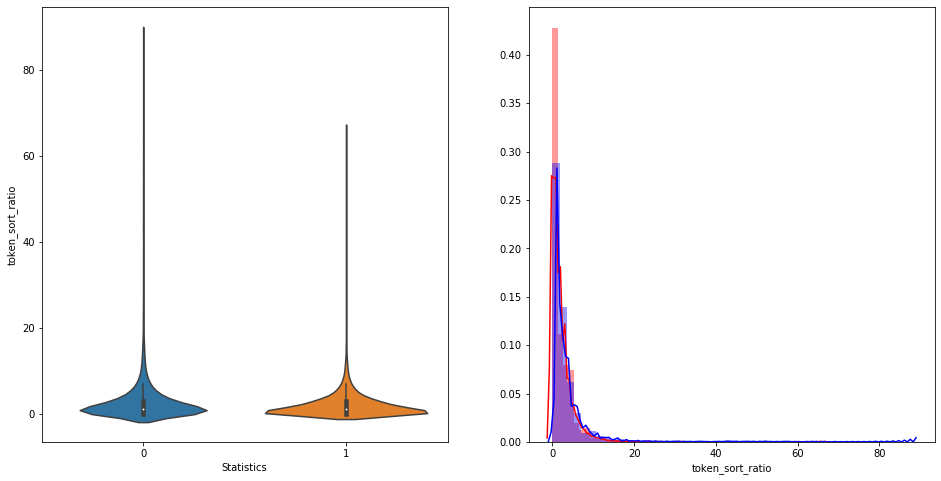

for Quantitative Biology


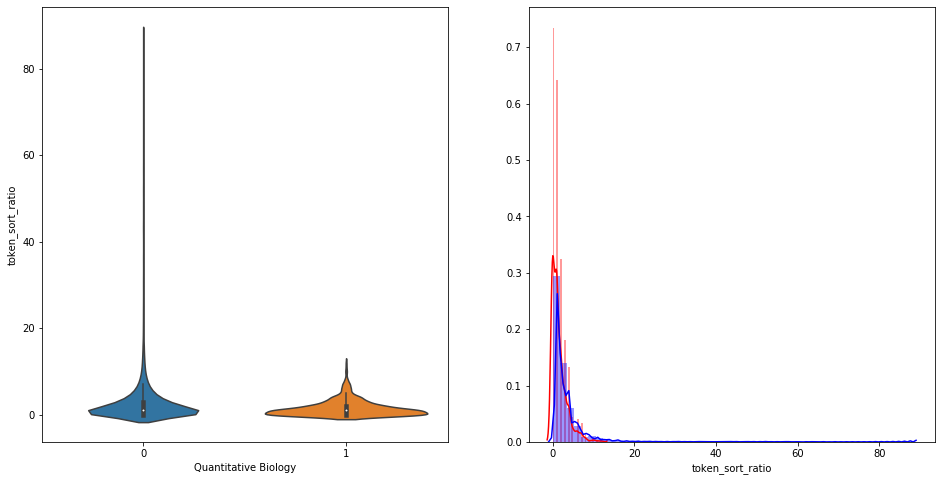

for Quantitative Finance


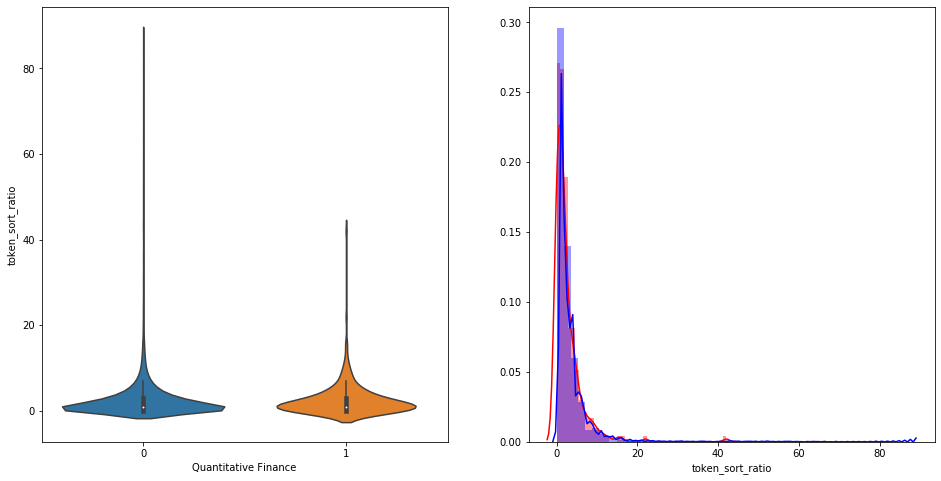

In [32]:
col=df.columns
col=col[3:9]
print(col)
for k in col:
    plt.figure(figsize=(16, 8))

    plt.subplot(1,2,1)
    sns.violinplot(x = k , y = 'token_sort_ratio', data = df[0:] , )

    plt.subplot(1,2,2)
    sns.distplot(df[df[k] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
    sns.distplot(df[df[k] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
    print("for "+k)
    plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.022s...
[t-SNE] Computed neighbors for 5000 samples in 0.867s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.099954
[t-SNE] Computed conditional probabilities in 0.218s
[t-SNE] Iteration 50: error = 87.5580750, gradient norm = 0.0270587 (50 iterations in 3.835s)
[t-SNE] Iteration 100: error = 78.2230225, gradient norm = 0.0044631 (50 iterations in 3.033s)
[t-SNE] Iteration 150: error = 77.6026077, gradient norm = 0.0022443 (50 iterations in 2.450s)
[t-SNE] Iteration 200: error = 77.3861847, gradient norm = 0.0019927 (50 iterations in 2.480s)
[t-SNE] Iteration 250: error = 77.2719040, gradient norm = 0.0012371

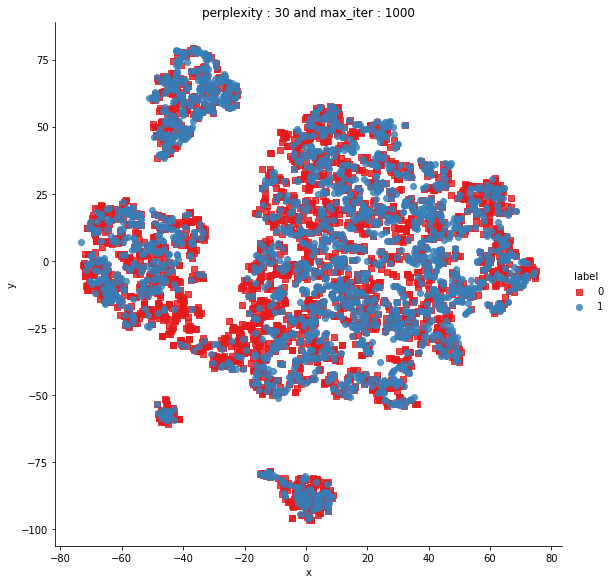

for Physics


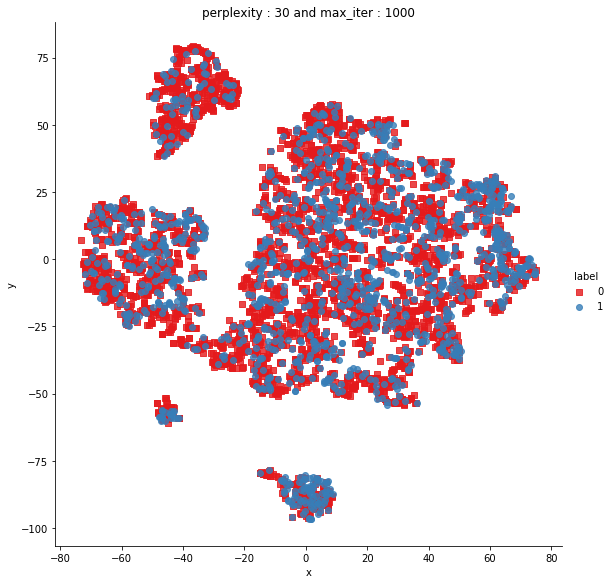

for Mathematics


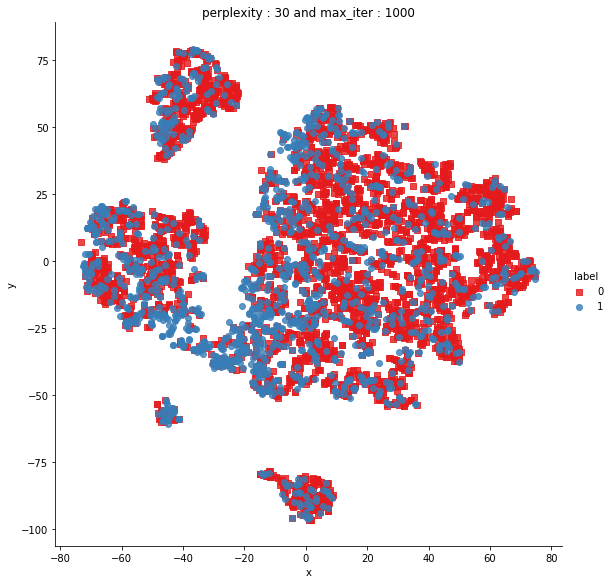

for Statistics


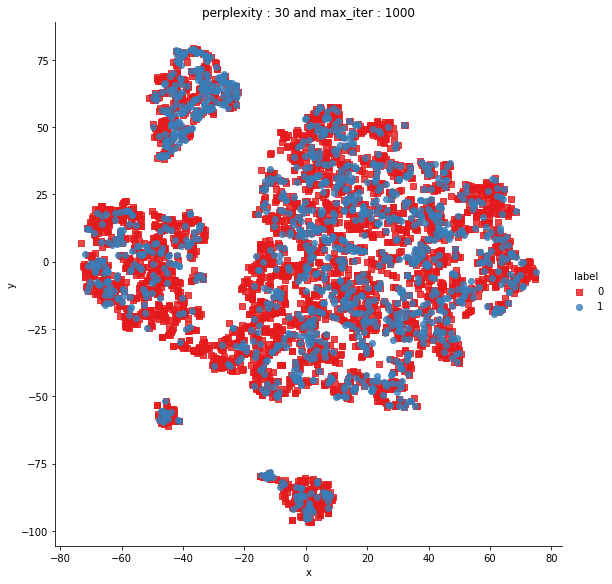

for Quantitative Biology


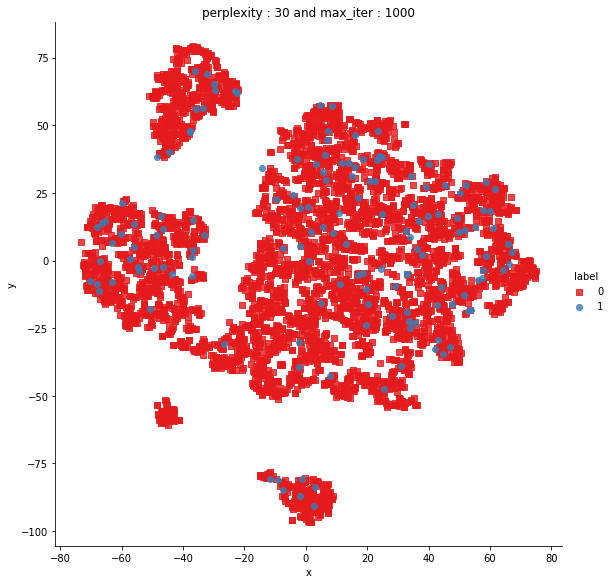

for Quantitative Finance


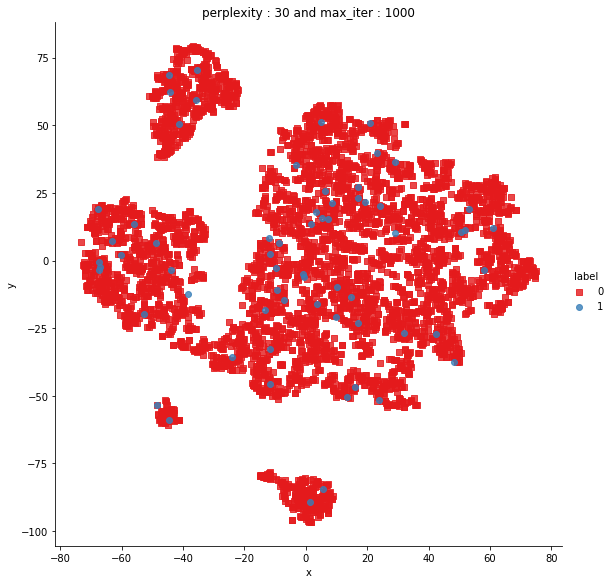

In [47]:
# Using TSNE for Dimentionality reduction for 15 Features 
# (Generated after cleaning the data) to 3 dimensions
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio', 'token_sort_ratio',  'fuzz_ratio', 'fuzz_partial_ratio', 'longest_substr_ratio']])
tsne2d = TSNE(n_components=2,init='random',random_state=101,method='barnes_hut',n_iter=1000,verbose=2,angle=0.5).fit_transform(X)
col=df.columns
col=col[3:9]
for i in col:
    from sklearn.preprocessing import MinMaxScaler
    y = dfp_subsampled[i].values
    df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})
    # Draw the plot in appropriate place in the grid
    sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
    plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
    print("for "+i)
    plt.show()